In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display
import glob
from datetime import datetime,timedelta
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import streamlit as st


In [15]:
!pip install xgboost

In [16]:
 !pip install streamlit

In [17]:
locs = {'waiting_folder' : 'data/waiting times'}

In [5]:
#reading the data

In [18]:
waiting_times = list()
for attraction in tqdm(os.listdir(locs['waiting_folder'])):
    filename = os.path.join(locs['waiting_folder'], attraction)
    df = pd.read_csv(filename)
    if df.empty:
        continue
    df.insert(0, 'attraction', attraction.split('.')[0])
    waiting_times.append(df)

df_wait_raw = pd.concat(waiting_times, ignore_index=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 52/52 [00:14<00:00,  3.60it/s]


In [141]:
#data cleaning

In [19]:
df_wait = df_wait_raw.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

Removed 1318703 rows


In [20]:
# Extract "minutes from df_wait" from the datetime column
df_wait_post['minute'] = df_wait_post['datetime'].dt.hour * 60 + df_wait_post['datetime'].dt.minute

In [21]:
df_wait_post['attraction'].unique()

array(['7_dwarfs_train', 'alien_saucers', 'astro_orbiter', 'barnstormer',
       'big_thunder_mtn', 'buzz_lightyear', 'carousel_of_progress',
       'country_bears', 'dinosaur', 'dumbo', 'enchanted_tiki_rm',
       'expedition_everest', 'flight_of_passage', 'hall_of_presidents',
       'haunted_mansion', 'it_s_a_small_world', 'jungle_cruise',
       'kilimanjaro_safaris', 'laugh_floor', 'liberty_sq_riverboat',
       'mad_tea_party', 'magic_carpets', 'navi_river', 'peoplemover',
       'peter_pan_s_flight', 'philharmagic', 'pirates_of_caribbean',
       'pirate_s_adventure', 'princess_hall__cinderella_elena',
       'princess_hall__rapunzel_tiana', 'regal_carrousel',
       'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

In [10]:
#processing time shift only

In [ ]:
#interpolating and prepering  traing dataframe

In [22]:
groups_itp = []

for (date, attraction), group in tqdm(df_wait.groupby(['date', 'attraction'])):
    time_shifted = group['datetime'] - timedelta(hours=3)
    group['minute'] = 3 * 60 + time_shifted.dt.hour * 60 + time_shifted.dt.minute

    if not {'SACTMIN', 'SPOSTMIN'}.issubset(group.columns):
        continue

    # Check if there's enough non-NaN data to interpolate
    if group[['SACTMIN', 'SPOSTMIN']].dropna(how='all').empty:
        continue  # Skip if there's nothing to work with

    group = group.drop(columns=['datetime', 'attraction', 'date'], errors='ignore')
    group = group.groupby('minute', as_index=False)[['SACTMIN', 'SPOSTMIN']].mean()

    new_index = np.arange(0, 27 * 60 + 1, 30)
    group = group.set_index('minute')

    # REINDEX ONLY IF INDEX ISN'T EMPTY
    if group.index.empty:
        continue

    reindexed = group.reindex(np.unique(np.concatenate([new_index, group.index]))).interpolate(method='linear')

    resampled = reindexed.loc[new_index].reset_index()

    for col in ['SACTMIN', 'SPOSTMIN']:
        if col in resampled.columns:
            resampled[col] = ((resampled[col] + 2.5) // 5) * 5

    resampled['SPOSTMIN_interp'] = resampled['SPOSTMIN'].interpolate(method='linear')

    # Avoid dividing by zero or NaN
    if 'SACTMIN' in resampled.columns and 'SPOSTMIN_interp' in resampled.columns:
        resampled['actual_over_posted'] = resampled['SACTMIN'] / resampled['SPOSTMIN_interp']

    resampled.insert(0, 'date', date)
    resampled.insert(1, 'attraction', attraction)

    groups_itp.append(resampled)


100%|████████████████████████████████████████████████████████████████████████████| 77543/77543 [06:53<00:00, 187.71it/s]


In [23]:
df_netjes_itp = pd.concat(groups_itp, ignore_index=True)

In [24]:
df_netjes_itp.sample(20)

,date,attraction,minute,SACTMIN,SPOSTMIN,SPOSTMIN_interp,actual_over_posted
2838014,2019-05-18,rock_n_rollercoaster,420,NaN,NaN,NaN,NaN
2327236,2018-09-07,flight_of_passage,630,55.0,90.0,90.0,0.611111
3055596,2019-09-04,magic_carpets,480,NaN,NaN,NaN,NaN
2934739,2019-07-05,slinky_dog,1470,55.0,30.0,30.0,1.833333
2930239,2019-07-03,navi_river,120,NaN,NaN,NaN,NaN
3996719,2021-08-17,7_dwarfs_train,1020,30.0,50.0,50.0,0.600000
422221,2015-09-15,under_the_sea,1230,0.0,10.0,10.0,0.000000
4259919,2021-12-26,navi_river,120,NaN,NaN,NaN,NaN
3487614,2020-11-16,pirates_of_caribbean,270,NaN,NaN,NaN,NaN
1239075,2017-01-27,magic_carpets,1050,NaN,25.0,25.0,NaN


In [25]:
# Median ratio per attraction (or could group by time buckets too)
median_ratios = df_netjes_itp.groupby('attraction')['actual_over_posted'].median()

# Function to impute SACTMIN
def impute_actual(row):
    if pd.isna(row['SACTMIN']):
        ratio = median_ratios.get(row['attraction'], 0.7)  # fallback value
        return row['SPOSTMIN_interp'] * ratio
    return row['SACTMIN']

df_netjes_itp['SACTMIN_filled'] = df_netjes_itp.apply(impute_actual, axis=1)


In [31]:
df_netjes_itp.isnull().sum()

date                        0
attraction                  0
minute                      0
SACTMIN               2437351
SPOSTMIN              1497627
SPOSTMIN_interp       1497627
actual_over_posted    2513249
SACTMIN_filled        1438483
dtype: int64

In [35]:
# Step 1: Drop rows where either wait time is missing
df_netjes_clean = df_netjes_itp.dropna(subset=['SPOSTMIN_interp', 'SACTMIN_filled']).copy()

# Step 2: Optional – if you want to keep and fill some other columns (like actual_over_posted), do it here
df_netjes_clean['actual_over_posted'] = df_netjes_clean['actual_over_posted'].fillna(0)

# Step 3: Re-check
print("Remaining null values:")
print(df_netjes_clean.isnull().sum())


Remaining null values:
date                       0
attraction                 0
minute                     0
SACTMIN               998868
SPOSTMIN                   0
SPOSTMIN_interp            0
actual_over_posted         0
SACTMIN_filled             0
dtype: int64


In [36]:
df_netjes_clean = df_netjes_clean.drop(columns=['SACTMIN'])

In [38]:
df_netjes_clean.isnull().sum()

date                  0
attraction            0
minute                0
SPOSTMIN              0
SPOSTMIN_interp       0
actual_over_posted    0
SACTMIN_filled        0
dtype: int64

In [39]:
df_netjes_itp.to_csv("data/clean/cleandata.csv")

In [40]:
# Pivot heatmap
heatmap_data = df_netjes_itp.copy()
heatmap_data['hour'] = heatmap_data['minute'] // 60
pivot = heatmap_data.pivot_table(index='attraction', columns='hour', values='SACTMIN_filled', aggfunc='mean')


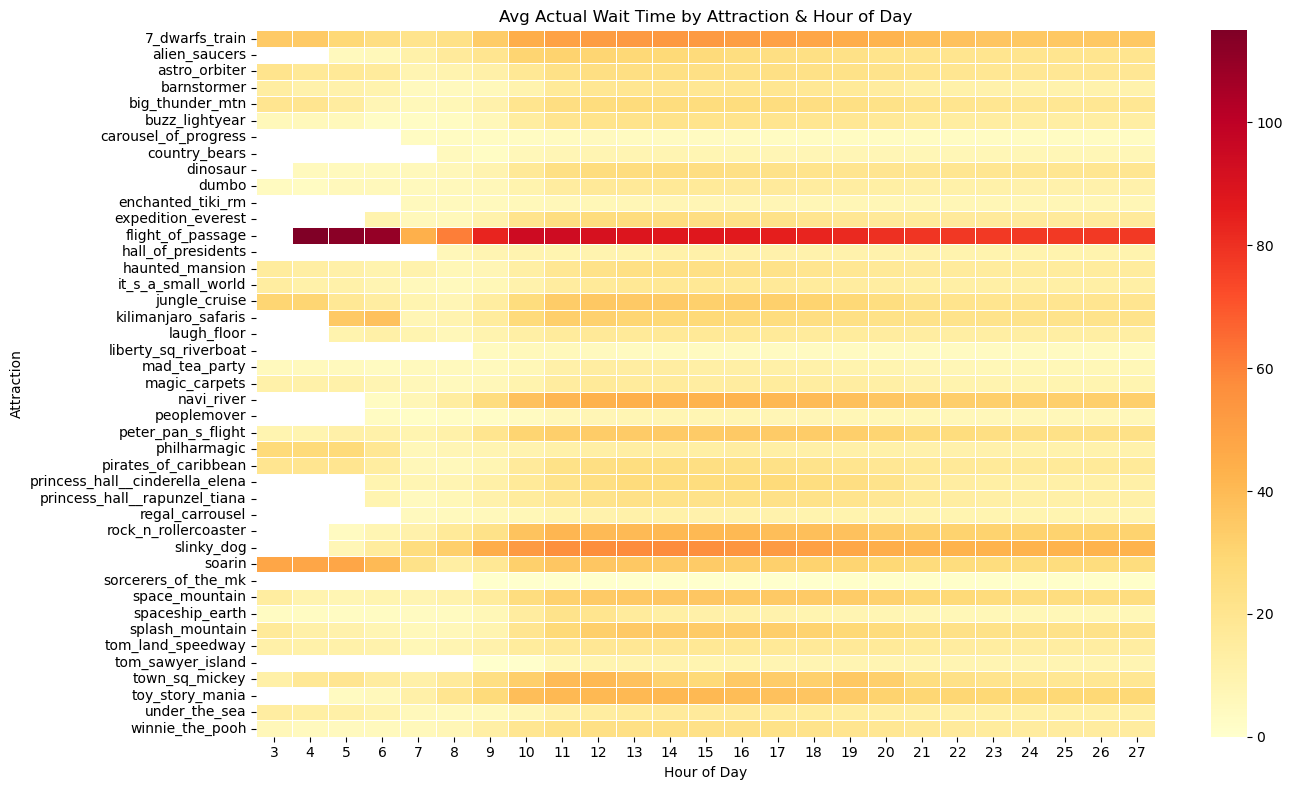

In [41]:
plt.figure(figsize=(14, 8))

# Create the heatmap
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.5, annot=False)

# Labels and formatting
plt.title("Avg Actual Wait Time by Attraction & Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Attraction")
plt.tight_layout()
plt.show()


In [ ]:
flight of passage has 100+ wait minutes
followed by slinky_dog, 7_dwarfs_train, and soarin
27 hours - This was done to time-shift the data to align better across days or to capture overnight queues/events.
from open to 9am must rides show light yellow
underutilized attraction can be used to absorb overflow

# Box Plot of Wait Time Distributions per Attraction

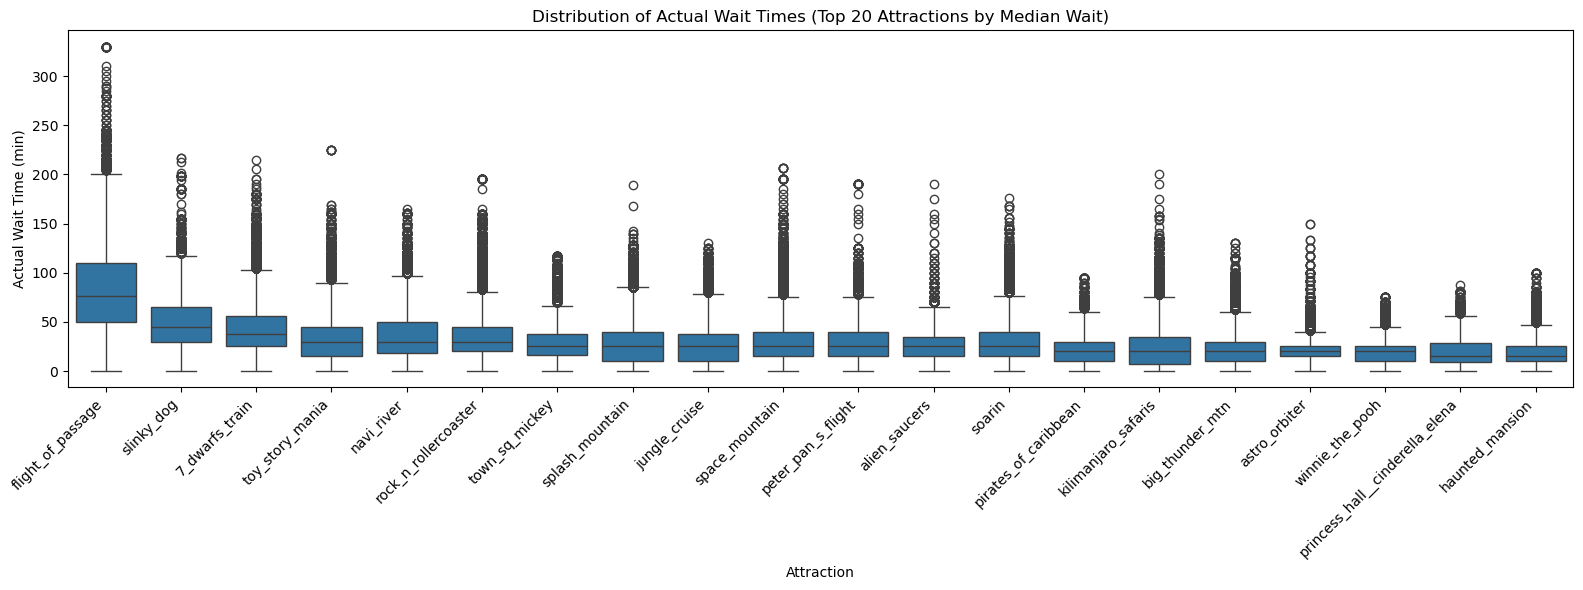

In [42]:
# Optional: sort attractions by median wait time
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get top 20 attractions by median actual wait time
top20_median = (
    df_netjes_itp.groupby('attraction')['SACTMIN_filled']
    .median()
    .sort_values(ascending=False)
    .head(20)
    .index
)

# Step 2: Filter original data for only top 20 attractions
filtered_df = df_netjes_itp[df_netjes_itp['attraction'].isin(top20_median)]

# Step 3: Sort those top 20 for boxplot ordering
ordered = (
    filtered_df.groupby('attraction')['SACTMIN_filled']
    .median()
    .sort_values(ascending=False)
    .index
)

# Step 4: Plot
plt.figure(figsize=(16, 6)) 
sns.boxplot(
    data=filtered_df,
    x='attraction',
    y='SACTMIN_filled',
    order=ordered
)

plt.xticks(rotation=45, ha='right') 
plt.title("Distribution of Actual Wait Times (Top 20 Attractions by Median Wait)")
plt.ylabel("Actual Wait Time (min)")
plt.xlabel("Attraction")
plt.tight_layout()
plt.show()


In [ ]:
Top 3 Longest Waits flight_of_passage:
Median wait ~80+ min
Huge spread and extreme outliers hitting 300+ mins
Most high-pressure ride to manage.

slinky_dog and 7_dwarfs_train:
Medians around 50 and outliers 

Moderate-to-High Wait Time Group show 40-60 min
toy_story_mania, rock_n_rollercoaster, navi_river, space_mountain, peter_pan_s_flight

Low-Wait, High-Throughput or Niche Attractions
carousel_of_progress, country_bears, hall_of_presidents, liberty_sq_riverboat, swiss_family_tree

# Daily Trend of Actual vs Posted

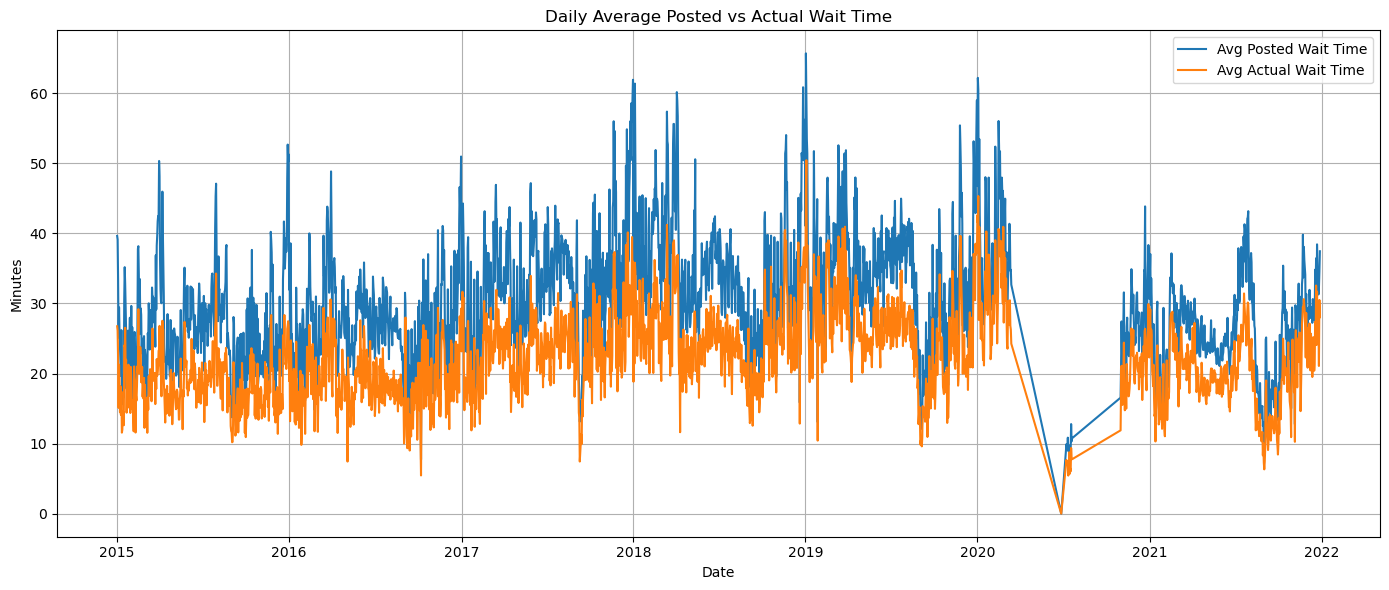

In [43]:
daily_avg = df_netjes_itp.groupby(df_netjes_itp['date'])[['SPOSTMIN_interp', 'SACTMIN_filled']].mean().reset_index()

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(daily_avg['date'], daily_avg['SPOSTMIN_interp'], label='Avg Posted Wait Time')
plt.plot(daily_avg['date'], daily_avg['SACTMIN_filled'], label='Avg Actual Wait Time')
plt.title('Daily Average Posted vs Actual Wait Time')
plt.xlabel('Date')
plt.ylabel('Minutes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Average Overestimation per Attraction

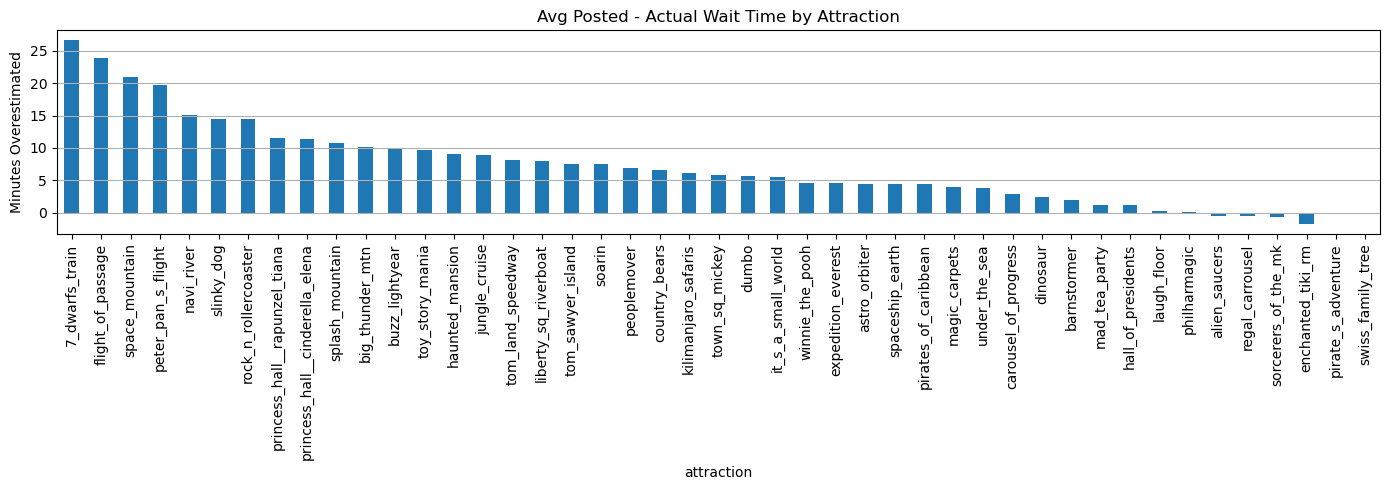

In [29]:
gap = df_netjes_itp.groupby('attraction')[['SPOSTMIN_interp', 'SACTMIN_filled']].mean()
gap['overestimation'] = gap['SPOSTMIN_interp'] - gap['SACTMIN_filled']
gap = gap.sort_values('overestimation', ascending=False)

gap['overestimation'].plot(kind='bar', figsize=(14, 5), title='Avg Posted - Actual Wait Time by Attraction')
plt.ylabel("Minutes Overestimated")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


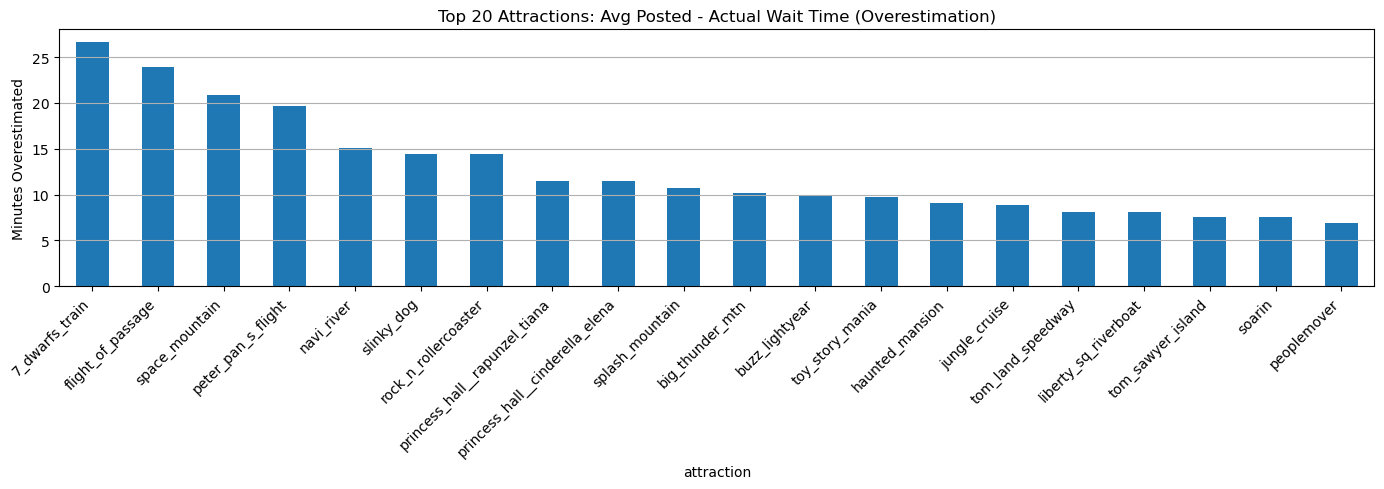

In [29]:
import matplotlib.pyplot as plt

# Step 1: Compute mean posted and actual wait times per attraction
gap = df_netjes_itp.groupby('attraction')[['SPOSTMIN_interp', 'SACTMIN_filled']].mean()

# Step 2: Calculate overestimation
gap['overestimation'] = gap['SPOSTMIN_interp'] - gap['SACTMIN_filled']

# Step 3: Sort and keep top 20
gap = gap.sort_values('overestimation', ascending=False).head(20)

# Step 4: Plot
gap['overestimation'].plot(
    kind='bar', 
    figsize=(14, 5), 
    title='Top 20 Attractions: Avg Posted - Actual Wait Time (Overestimation)'
)

plt.ylabel("Minutes Overestimated")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
7_dwarfs_train: ~26 mins overestimated

flight_of_passage, space_mountain, peter_pan_s_flight: all around 20–25 min inflated

Implication: These attractions are consistently overstated. This might:

Help spread out guest flow (intentionally)

Reflect outdated or conservative queue algorithms

Lead to distrust in posted wait times over time


Moderately Inflated Rides
Middle section (8–15 mins over):

slinky_dog, rock_n_rollercoaster, navi_river, splash_mountain

Implication: These are probably for boarding delays.

Fair or Accurate Rides
Bottom right:

pirates_of_caribbean, magic_carpets, under_the_sea, carousel_of_progress, dinosaur     


Understaters
If any attractions dip below 0:

That means they underestimate wait time, i.e., guests wait longer than posted.

Implication: Operationally risky — might trigger guest complaints or app distrust if persistent.

# Top 5 Attractions with Most Total Lost Time

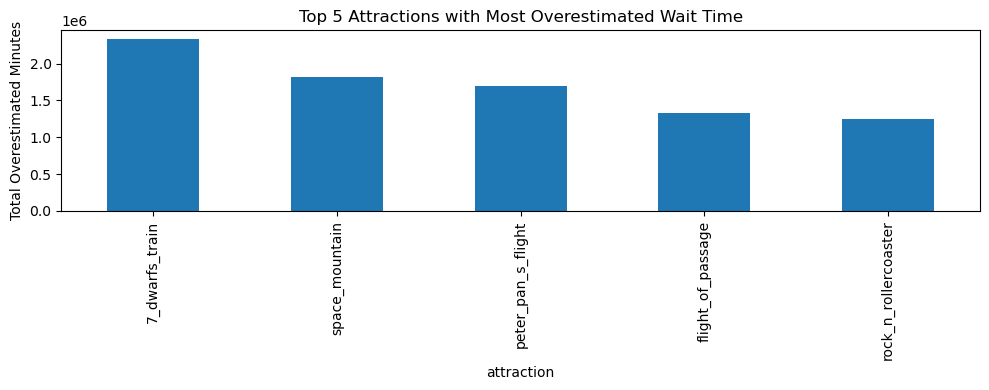

In [31]:
lost_time = df_netjes_itp.copy()
lost_time['lost_minutes'] = lost_time['SPOSTMIN_interp'] - lost_time['SACTMIN_filled']
top_lost = lost_time.groupby('attraction')['lost_minutes'].sum().sort_values(ascending=False).head(5)

top_lost.plot(kind='bar', figsize=(10, 4), title='Top 5 Attractions with Most Overestimated Wait Time')
plt.ylabel("Total Overestimated Minutes")
plt.tight_layout()
plt.show()
